# Introduction

The temperature measurement is done with the following circuit:

![](schematic-sensor.png)

The value of the thermistor is defined as $ R_T=R_N \cdot e^{B \cdot \left(\frac{1}{T} - \frac{1}{T_N}\right)} $ with $ T_N = 298.15 $. 

This results in: $ T = \frac{B \cdot T_N}{B + \ln\left( \frac{R_T}{R_N} \right) \cdot T_N} $

*Please note: Temperature values must be given in Kelvin.*

Based on the following equations:
$$
\begin{align}
U_4 &= U_3 + U_1 + U_2 \\
V_{CC} &= U_{R_T} + U_4 \\
I &= I_3 + I_4
\end{align}
$$

and
$$

$$

In [59]:
from IPython.display import Markdown as md
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

In [60]:
pt1000 = np.array([[-20, -15, -10, -5, 0,5,10,15,20,25,30],[8194, 6256, 4825, 3758, 2954, 2342,1872,1508,1224,1000,823]])
R_N = 1000
T_N = 298.15

In [61]:
def R_T_func(T, B):
    return R_N * np.exp(B*(1/T - 1/T_N)) 

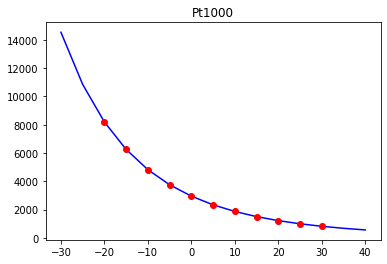

In [112]:
pt_parameter, covariance_matrix = curve_fit(R_T_func, pt1000[0]+273.15, pt1000[1])
x_data = np.arange(-30, 41, 5)
y_data = R_T_func(x_data+273.15, *pt_parameter)

plt.plot(x_data, y_data, 'b-', label='fit')
plt.plot(pt1000[0], pt1000[1], 'ro')
plt.title('Pt1000');

In [113]:
md("Based on model data we get $B={:.2f}$.".format(pt_parameter[0]))

Based on model data we get $B=3528.01$.

## Calculating the temperature

To actually calculate the current temperature from a given ADC-value we need to

1. get a general idea what the formula looks like
2. sample data

In [121]:
raw = np.array([787, 780, 773, 754, 749, 729, 717, 722, 725, 731.3])
temp = np.array([28.1, 27, 26.7, 24.4, 24, 21.5, 20.3, 20.7, 21, 21.6])+273.15

Linear approach: $ T = m \cdot raw + b $

In [122]:
# linear approach
def T_func(raw, m, b):
    return m * raw + b

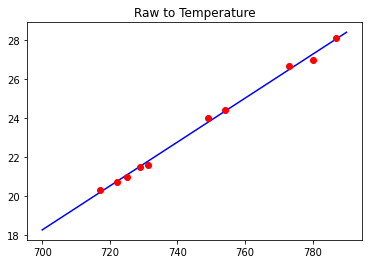

In [123]:
T_parameter, covariance_matrix = curve_fit(T_func, raw, temp)
x_data = np.arange(700, 800, 10)
y_data = T_func(x_data, *T_parameter)

plt.plot(x_data, y_data-273.15, 'b-', label='fit')
plt.plot(raw, temp-273.15, 'ro', label='data')
plt.title('Raw to Temperature');

In [120]:
md("Based on linear model we get $m={:.3f}$ and $b={:.3f}$.".format(T_parameter[0], T_parameter[1]))

Based on linear model we get $m=0.112$ and $b=212.832$.